# Test Notebook


## **Multi-Round Execution** 
Automatic computation of the algorithm.

### First Section:
Single Execution of the algorithm
### Second Section:
Average of results during multiple executions (score and losses are averaged).

In [61]:
import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


# First Section

In [62]:
num_workers = 4
num_rounds = 20

m = -2.9
c = 1.1

In [63]:
dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(1)

dataset_X = dataset_X.reshape(-1,1)

In [64]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [65]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [66]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [67]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [68]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))
    

------ROUND 1------
Mean squared error: 1.189
Coefficient of determinaton: 0.983 

------ROUND 2------
Mean squared error: 1.140
Coefficient of determinaton: 0.984 

------ROUND 3------
Mean squared error: 1.149
Coefficient of determinaton: 0.984 

------ROUND 4------
Mean squared error: 1.163
Coefficient of determinaton: 0.983 

------ROUND 5------
Mean squared error: 1.160
Coefficient of determinaton: 0.983 

------ROUND 6------
Mean squared error: 1.152
Coefficient of determinaton: 0.983 

------ROUND 7------
Mean squared error: 1.159
Coefficient of determinaton: 0.983 

------ROUND 8------
Mean squared error: 1.158
Coefficient of determinaton: 0.983 

------ROUND 9------
Mean squared error: 1.159
Coefficient of determinaton: 0.983 

------ROUND 10------
Mean squared error: 1.164
Coefficient of determinaton: 0.983 

------ROUND 11------
Mean squared error: 1.167
Coefficient of determinaton: 0.983 

------ROUND 12------
Mean squared error: 1.165
Coefficient of determinaton: 0.983 

-

<Figure size 432x288 with 0 Axes>

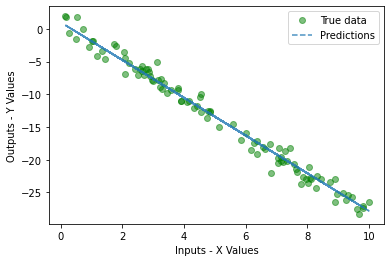

In [69]:
plt.clf()

ax = plt.figure().gca()

plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')

ax.set_xlabel("Inputs - X Values")
ax.set_ylabel("Outputs - Y Values")

plt.show()

<Figure size 720x360 with 0 Axes>

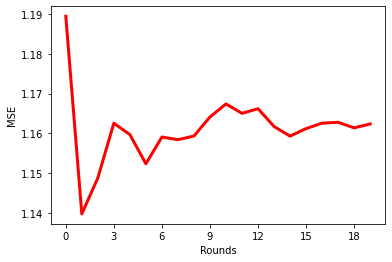

In [70]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()


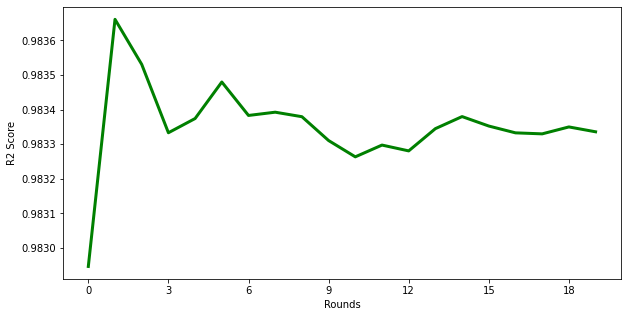

In [71]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")

plt.draw()

In [72]:
N = len(test_X)
p = len(test_X[0]) + 1


X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = test_X

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ test_y
print(beta_hat)

y_hat = pred_server
residuals = test_y - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

[ 1.25549073 -2.94015448]
SE(beta_hat[0]): 0.2253075324722199
SE(beta_hat[1]): 0.038655796099122466


## Evaluating only the single worker

In [73]:
worker_list = []
worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


error_single = []
score_single = []

for i in range(0, num_rounds):
    
    worker_list[0].train(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error_single.append(mean_squared_error(test_y, pred_server))
    score_single.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 1.155
Coefficient of determinaton: 0.983 

------ROUND 2------
Mean squared error: 1.158
Coefficient of determinaton: 0.983 

------ROUND 3------
Mean squared error: 1.153
Coefficient of determinaton: 0.983 

------ROUND 4------
Mean squared error: 1.193
Coefficient of determinaton: 0.983 

------ROUND 5------
Mean squared error: 1.197
Coefficient of determinaton: 0.983 

------ROUND 6------
Mean squared error: 1.161
Coefficient of determinaton: 0.983 

------ROUND 7------
Mean squared error: 1.173
Coefficient of determinaton: 0.983 

------ROUND 8------
Mean squared error: 1.177
Coefficient of determinaton: 0.983 

------ROUND 9------
Mean squared error: 1.176
Coefficient of determinaton: 0.983 

------ROUND 10------
Mean squared error: 1.179
Coefficient of determinaton: 0.983 

------ROUND 11------
Mean squared error: 1.175
Coefficient of determinaton: 0.983 

------ROUND 12------
Mean squared error: 1.183
Coefficient of determinaton: 0.983 

-

<Figure size 720x360 with 0 Axes>

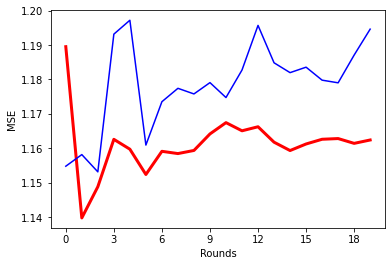

In [74]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)
plt.plot(x, error_single, color='blue')

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()


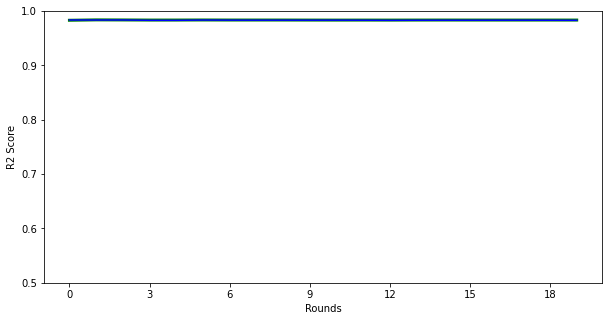

In [75]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, score_single, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([0.5,1])

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")

plt.draw()

In [76]:
N = len(test_X)
p = len(test_X[0]) + 1


X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = test_X

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ test_y
print(beta_hat)

y_hat = pred_server
residuals = test_y - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

[ 1.25549073 -2.94015448]
SE(beta_hat[0]): 0.22840924256192835
SE(beta_hat[1]): 0.0391879535084676


In [77]:
worker_list = []
worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


error_single = []
score_single = []


for i in range(0, num_rounds):
    
    worker_list[0].model.fit(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])
    
    pred_server = worker_list[0].model.predict(test_X)
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error_single.append(mean_squared_error(test_y, pred_server))
    score_single.append(r2_score(test_y, pred_server))

------ROUND 0------
Mean squared error: 1.155
Coefficient of determinaton: 0.983 

------ROUND 1------
Mean squared error: 1.172
Coefficient of determinaton: 0.983 

------ROUND 2------
Mean squared error: 1.283
Coefficient of determinaton: 0.982 

------ROUND 3------
Mean squared error: 1.720
Coefficient of determinaton: 0.975 

------ROUND 4------
Mean squared error: 1.270
Coefficient of determinaton: 0.982 

------ROUND 5------
Mean squared error: 1.226
Coefficient of determinaton: 0.982 

------ROUND 6------
Mean squared error: 1.342
Coefficient of determinaton: 0.981 

------ROUND 7------
Mean squared error: 1.211
Coefficient of determinaton: 0.983 

------ROUND 8------
Mean squared error: 1.166
Coefficient of determinaton: 0.983 

------ROUND 9------
Mean squared error: 2.110
Coefficient of determinaton: 0.970 

------ROUND 10------
Mean squared error: 1.165
Coefficient of determinaton: 0.983 

------ROUND 11------
Mean squared error: 1.323
Coefficient of determinaton: 0.981 

--

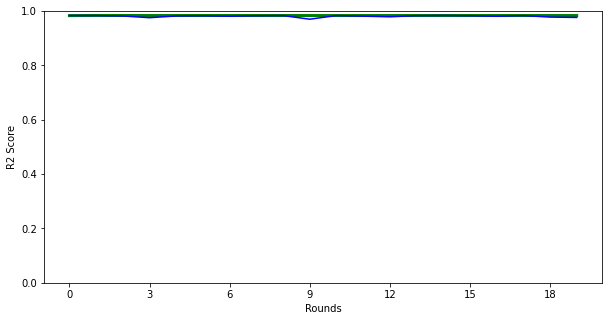

In [78]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, score_single, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([0,1])

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")

plt.draw()

## Second Section

In [79]:
num_workers = 4
num_rounds = 10

m = -2.9
c = 1.1



iterations = 10

error_list = []
score_list = []
error_list_single = []
score_list_single = []

for iteration in range(0, iterations):

    
    # Linear Regression Coefficients
    m = 1.4
    c = 10

    dataset_X = np.linspace(0, 10, 500)
    np.random.shuffle(dataset_X)

    dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(20)

    dataset_X = dataset_X.reshape(-1,1)
    dataset_y = dataset_y.reshape(-1,1)
    
    train_percentage = 0.9


    train_X, test_X = np.split(dataset_X, 
                [int(train_percentage * len(dataset_X))
                ])

    train_y, test_y = np.split(dataset_y, 
                [int(train_percentage * len(dataset_y))
                ])
    
    train_list_X = splitDataset(train_X, num_workers, num_rounds)
    train_list_y = splitDataset(train_y, num_workers, num_rounds)
    
    worker_list = []
    
    
    for i in range(0, num_workers):
        worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))
        
        
    server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)
    
    
    from collections import defaultdict

    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)


    error = []
    score = []



    for i in range(0, num_rounds):

        for j in range(0, num_workers):

            worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
            pred_worker = worker_list[j].evaluate(test_X)

            # store loss info for current epoch 
            worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))

        server.aggregation() 
        server.return_to_workers()

        pred_server = server.evaluate(test_X)
        error.append(mean_squared_error(test_y, pred_server))
        score.append(r2_score(test_y, pred_server))
        
    error_list.append(error)
    score_list.append(score)
    
    worker_list = []
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

    server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


    error_single = []
    score_single = []

    for i in range(0, num_rounds):

        worker_list[0].train(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])

        server.aggregation() 
        server.return_to_workers()

        pred_server = server.evaluate(test_X)
        error_single.append(mean_squared_error(test_y, pred_server))
        score_single.append(r2_score(test_y, pred_server))
    
    
    error_list_single.append(error_single)
    score_list_single.append(score_single)

In [80]:
err = []
for i in range(0, len(error_list[0])):
    s = 0
    for k in error_list:
        s += k[i]
    err.append(s / len(error_list))


sc = []
for i in range(0, len(score_list[0])):
    s = 0
    for k in score_list:
        s += k[i]
    sc.append(s / len(score_list))


err_s = []
for i in range(0, len(error_list_single[0])):
    s = 0
    for k in error_list_single:
        s += k[i]
    err_s.append(s / len(error_list_single))


sc_s = []
for i in range(0, len(score_list_single[0])):
    s = 0
    for k in score_list_single:
        s += k[i]
    sc_s.append(s / len(score_list_single))

<Figure size 720x360 with 0 Axes>

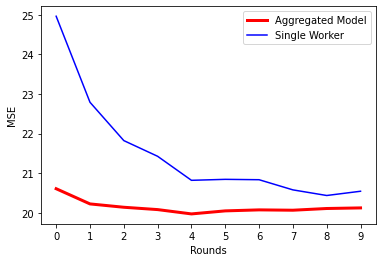

In [81]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, err, color='red', label='Aggregated Model', linewidth=3)
plt.plot(x, err_s, color='blue', label='Single Worker')
plt.legend(loc='best')

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()

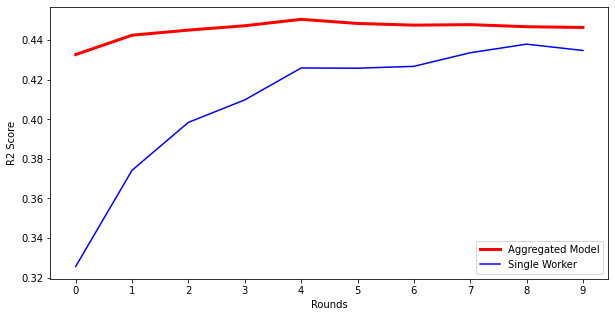

In [82]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, sc, color='red',label='Aggregated Model', linewidth=3)
plt.plot(x, sc_s, color='blue', label='Single Worker')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")
plt.legend(loc='best')

plt.draw()